# Utilizando a base do Diário Oficial da União

----

Exemplo de utilização de dados do projeto [Base dos Dados](http://basedosdados.org), elaborado por [Henrique Xavier](https://github.com/hsxavier) - Dúvidas e comentários: [hsxavier@gmail.com](mailto:hsxavier@gmail.com)

In [1]:
import pandas as pd
import matplotlib.pyplot as pl

## Exemplo 1 - Número de MPs e decretos ao longo do tempo

Vamos contabilizar o número de medidas provisórias e decretos publicados por mês, de abril de 2019 a março de 2021.

**Query**

É preciso rodar a query abaixo e salvar o resultado num arquivo CSV para ser lido em seguida:

    SELECT 
      EXTRACT(YEAR FROM data_publicacao) AS ano, 
      EXTRACT(MONTH FROM data_publicacao) AS mes, 
      COUNTIF(titulo LIKE '%MEDIDA PROVISÓRIA%' AND titulo NOT LIKE '%(*)%') AS n_mpv, 
      COUNTIF(titulo LIKE '%DECRETO%' AND titulo NOT LIKE '%LEGISLATIVO%' AND titulo NOT LIKE '%(*)%') AS n_decreto, 
      COUNT(*) AS n_tudo 
    FROM `basedosdados.br_imprensa_nacional_dou.secao_1` 
    GROUP BY ano, mes
    ORDER BY ano, mes

### Carrega os dados

In [2]:
# Carrega os dados (talvez você precise mudar o caminho para o arquivo):
df = pd.read_csv('../dados/dou_sec1_mpv_decreto_counts.csv')

# Organiza os dados:
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str) + '-01')
df = df.set_index('data')

In [3]:
# Exemplo dos dados obtidos com a query:
df.sample(5)

,ano,mes,n_mpv,n_decreto,n_tudo
data,,,,,
2019-07-01,2019,7,2,47,5371
2019-09-01,2019,9,3,35,5483
2019-10-01,2019,10,5,51,5576
2019-08-01,2019,8,4,51,5714
2020-12-01,2020,12,14,40,7675


### Compara o número de MPs com o número de outros tipos de atos

In [4]:
def normalize(series):
    """
    Calcula a variação, em %, de uma série temporal em relação à sua média.
    """
    return (series / series.mean() - 1) * 100

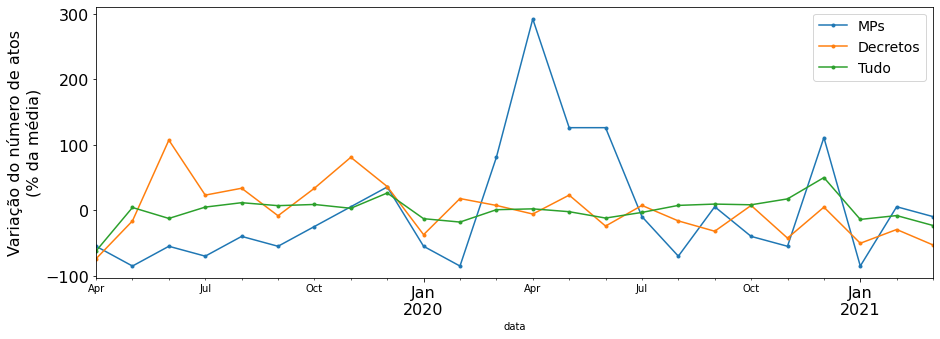

In [5]:
# Variação no número de publicações de cada tipo ao longo do tempo:

pl.figure(figsize=(15,5))

normalize(df['n_mpv']).plot(label='MPs', marker='.')
normalize(df['n_decreto']).plot(label='Decretos', marker='.')
normalize(df['n_tudo']).plot(label='Tudo', marker='.')

pl.ylabel('Variação do número de atos\n(% da média)', fontsize=16)
pl.legend(fontsize=14)
pl.tick_params(labelsize=16)
pl.show()

### Número absoluto de MPs ao longo do tempo

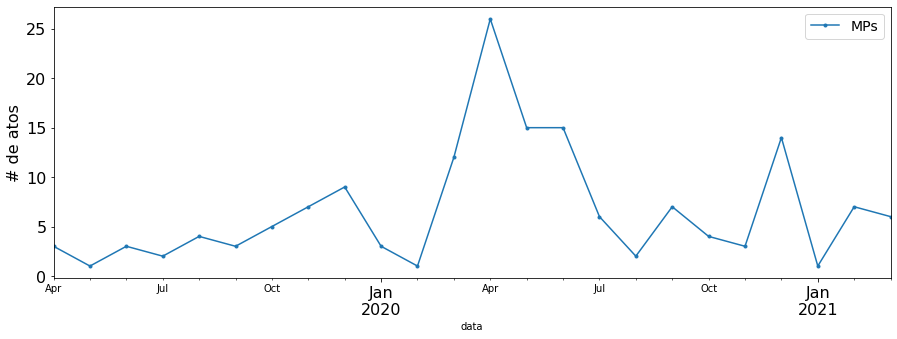

In [6]:
pl.figure(figsize=(15,5))

df['n_mpv'].plot(label='MPs', marker='.')

pl.ylabel('# de atos', fontsize=16)
pl.legend(fontsize=14)
pl.tick_params(labelsize=16)
pl.show()

## Exemplo 2 - Cloroquina na seção 3

Vamos verificar em qual período surgiram mais matérias na seção 3 (que trata de licitações e contratos do governo federal) com os termos "cloroquina" e "respirador".

Em seguida, vamos identificar quais os tipos de atos que contém esses termos (Avisos de licitação, Contratos, Extratos de dispensa de licitação, pregão eletrônico, tomada de preços, etc).

### Contagem de matérias

**Query**

É preciso rodar a query abaixo e salvar o resultado num arquivo CSV para ser lido em seguida:

    SELECT 
      EXTRACT(YEAR FROM data_publicacao) AS ano, 
      EXTRACT(MONTH FROM data_publicacao) AS mes, 
      COUNTIF(REGEXP_CONTAINS(texto_completo, '(?i)cloroquina')) AS n_cloroquina,
      COUNTIF(REGEXP_CONTAINS(texto_completo, '(?i)respirador')) AS n_respirador,
      COUNT(*) AS n_tudo
    FROM `basedosdados.br_imprensa_nacional_dou.secao_3` 
    GROUP BY ano, mes
    ORDER BY ano, mes

In [7]:
# Carrega os dados:
df = pd.read_csv('../dados/dou_sec3_cloroquina_counts.csv')

# Organiza os dados:
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str) + '-01')
df = df.set_index('data')

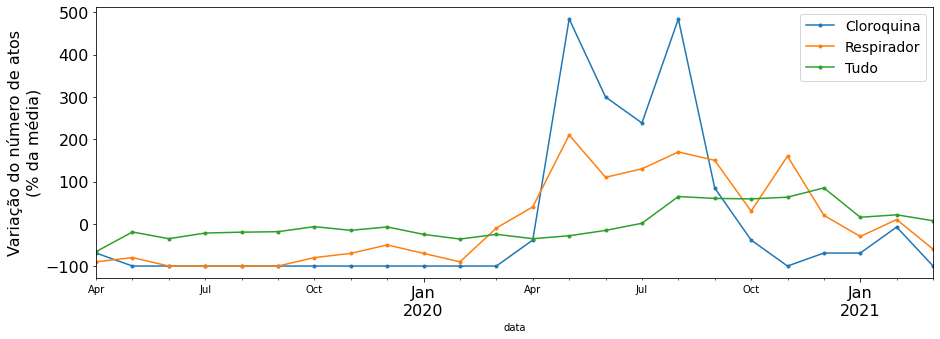

In [8]:
# Variação ao longo do tempo no número de publicações que contém cada palavra chave:

pl.figure(figsize=(15,5))

normalize(df['n_cloroquina']).plot(label='Cloroquina', marker='.')
normalize(df['n_respirador']).plot(label='Respirador', marker='.')
normalize(df['n_tudo']).plot(label='Tudo', marker='.')

pl.ylabel('Variação do número de atos\n(% da média)', fontsize=16)
pl.legend(fontsize=14)
pl.tick_params(labelsize=16)
pl.show()

### Tipo das matérias

Vamos agora identificar quais o tipos de matérias que mencionam essas palavras chave.

**Query**

É preciso rodar a query abaixo e salvar o resultado num arquivo CSV para ser lido em seguida:

    SELECT 
      titulo, 
      IF(REGEXP_CONTAINS(texto_completo, '(?i)cloroquina'), 1, 0) AS tem_cloroquina,
      IF(REGEXP_CONTAINS(texto_completo, '(?i)respirador'), 1, 0) AS tem_respirador,
    FROM `basedosdados.br_imprensa_nacional_dou.secao_3`
    WHERE data_publicacao_particao >= '2020-04-01' AND data_publicacao_particao <= '2020-09-01'


#### Prepara os dados

In [9]:
# Carrega os dados:

df = pd.read_csv('../dados/materias_sec3_com_sem_cloroquina.csv')
df.fillna('', inplace=True)
df.sample(5)

,titulo,tem_cloroquina,tem_respirador
133735,AVISO DE LICITAÇÃO | PREGÃO ELETRÔNICO Nº 2020...,0,0
80062,AVISO DE REABERTURA DE PRAZO | PREGÃO Nº 17/2020,0,0
130377,AVISO DE HOMOLOGAÇÃO E ADJUDICAÇÃO,0,0
64614,aviso DE ADJUDICAÇÃO E HOMOLOGAÇÃO,0,0
70255,AVISO DE LICITAÇÃO Nº 7003092471,0,0


In [10]:
# Quebra títulos múltiplos em várias linhas:

df['titulos'] = df['titulo'].str.split(' \| ')
df = df.explode('titulos', ignore_index=True)
df.sample(5)

,titulo,tem_cloroquina,tem_respirador,titulos
163429,EXTRATOs DE CONTRATOs,0,0,EXTRATOs DE CONTRATOs
90749,AVISO DE LICITAÇÃO | Pregão Eletrônico Nº 34/2...,0,0,Pregão Eletrônico Nº 34/2020 - UASG 179007
139911,Extrato dE Contrato,0,0,Extrato dE Contrato
28987,AVISO DE ALTERAÇÃO,0,0,AVISO DE ALTERAÇÃO
54365,AVISO DE REVOGAÇÃO | RDC ELETRÔNICO Nº 220/201...,0,0,AVISO DE REVOGAÇÃO


In [11]:
# Removendo termos inúteis do título:

regex_limpeza = '\(\*\)| d?e |[\dN]{1,2} ?[ºº°]|\d+|[\-/.]|janeiro|fevereiro|março|abril|maio|junho|julho|agosto|setembro|outubro|novembro|dezembro|uasg'
df['tokens'] = df['titulos'].str.replace(regex_limpeza, ' ', case=False)
df.sample(5)

,titulo,tem_cloroquina,tem_respirador,titulos,tokens
151882,AVISOS DE LICITAÇÃO | TOMADA DE PREÇO Nº 5/202...,0,0,TOMADA DE PREÇO Nº 7/2020 - CPL,TOMADA PREÇO CPL
160666,AVISO DE ALTERAÇÃO | PREGÃO Nº 157/2019,0,0,AVISO DE ALTERAÇÃO,AVISO ALTERAÇÃO
141714,extrato DE DISPENSA DE LICITAÇÃO,0,0,extrato DE DISPENSA DE LICITAÇÃO,extrato DISPENSA LICITAÇÃO
164471,AVISO DE LICITAÇÃO | PREGÃO PRESENCIAL SRP Nº ...,0,0,AVISO DE LICITAÇÃO,AVISO LICITAÇÃO
80629,EXTRATO DE NOTA DE EMPENHO,0,0,EXTRATO DE NOTA DE EMPENHO,EXTRATO NOTA EMPENHO


#### Conta a ocorrência de termos no título da matéria

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# Contando a frequência de palavras no título:

word_counter = CountVectorizer(binary=True)
contagem = word_counter.fit_transform(df['tokens']).toarray()
columns = word_counter.get_feature_names()
count_df = pd.DataFrame(data=contagem, columns=columns)
count_df.sample(5)

,aaviso,abaixo,abc,aberta,aberto,abertos,abertura,abin,abp,abr,...,às,àviso,área,áreas,âmbito,ético,íntegra,óleo,única,úteis
46059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Calcula a porcentagem de matérias que mencionam cada termo em seu título e as ordena por essa frequência:
all_counts = count_df.mean().sort_values(ascending=False) * 100

# Faz o mesmo, mas apenas para matérias contendo cloroquina:
cloro_counts = count_df.loc[df['tem_cloroquina'] == 1].mean()[all_counts.index] * 100

# Faz o mesmo, mas apenas para matérias contendo respirador:
resp_counts = count_df.loc[df['tem_respirador'] == 1].mean()[all_counts.index] * 100

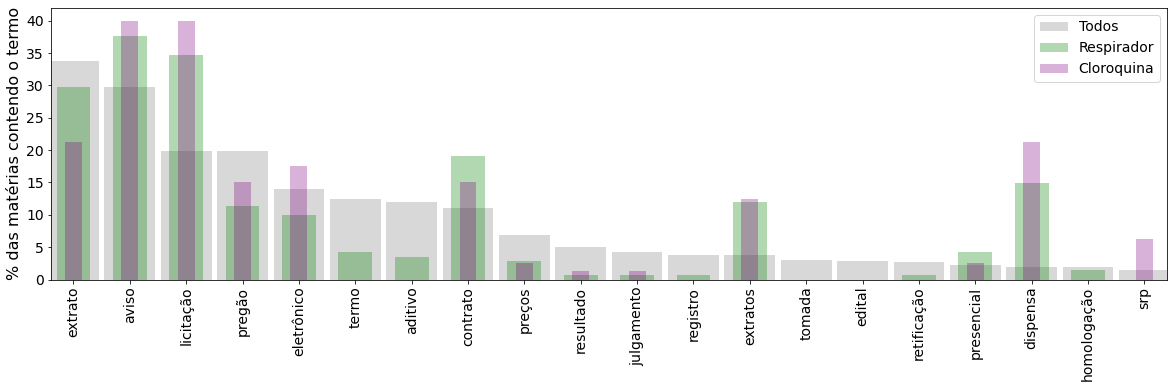

In [15]:
# Faz um gráfico com a frequência dos termos mais comuns:

pl.figure(figsize=(20,5))

all_counts.head(20).plot(kind='bar', color='gray', alpha=0.3, label='Todos', width=0.9)
resp_counts.head(20).plot(kind='bar', color='g', alpha=0.3, label='Respirador', width=0.6)
cloro_counts.head(20).plot(kind='bar', color='purple', alpha=0.3, label='Cloroquina', width= 0.3)

pl.ylabel('% das matérias contendo o termo', fontsize=16)
pl.legend(fontsize=14)
pl.tick_params(labelsize=14)
pl.show()

In [18]:
# Exemplos de matéria com cloroquina:
df.loc[df['tem_cloroquina'] == 1, 'titulos'].sample(20)

52936                                              DESPACHO
49605                      PREGÃO ELETRÔNICO SRP Nº 12/2020
204033                                 EXTRATOS DE CONTRATO
192216                                  Extrato de Contrato
49842             AVISO DE DISPENSA DE LICITAÇÃO Nº 28/2020
118196              RESULTADO De julgamento CHAMADA PÚBLICA
146303                                  EXTRATO DE CONTRATO
14393                                 EXTRATOS DE CONTRATOS
143401    Aviso De LicitaçãoPregão Eletrônico N° 57/CPL/...
189365                                    PREGÃO Nº 65/2020
168698           Pregão Eletrônico Nº 21/2020 - UASG 254446
86938                                 EXTRATOS DE CONTRATOS
86284      AVISO DE DISPENSA DE LICITAÇÃO Nº 141-2020 - SMS
118104                                EXTRATOS DE CONTRATOS
117558                      AVISOS DE dispensa de licitação
88601                                   EXTRATO DE CONTRATO
132837                      AVISOS DE DI